# Try to work with Mpc rather than armin, maybe make a second code
# TODO : 
- [ ] understand what's going on with covariance matrices
- [ ] understand how to better use patches 
- [ ] write preliminary results with cov = shot_noise 

In [1]:
import treecorr
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
from magnification_library import *
from sklearn.neighbors import KernelDensity
import coord

In [2]:
treecorr.__version__

'4.2.3'

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
#cosmo = extragalactic_cat.cosmology
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

In [5]:
def rand_cat(cat, Nobj, r=None, patch_centers=None, kde=None):
    
    ra_min = np.min(cat.ra)
    ra_max = np.max(cat.ra)
    dec_min = np.min(cat.dec)
    dec_max = np.max(cat.dec)

    rand_ra = np.random.uniform(ra_min, ra_max, int(Nobj))
    rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), int(Nobj))
    rand_dec = np.arcsin(rand_sindec)
    
    if kde != None:
        k_rand = kde.sample(int(Nobj))
    else:
        k_rand=None
        
    if r != None:
        r_rand = r.sample(int(Nobj))
    else:
        r_rand=None
        
    if isinstance(patch_centers, type(None)):
        cat_rand= treecorr.Catalog(ra=rand_ra, dec=rand_dec, r = r_rand, ra_units='radians', dec_units='radians', k=k_rand)
    else:
        cat_rand = treecorr.Catalog(ra=rand_ra, dec=rand_dec, r = r_rand, ra_units='radians', dec_units='radians', k=k_rand, patch_centers =patch_centers)       

    return cat_rand

In [65]:
def corr_quantities_NN(cat_halo, cat, rand, bin_dict, rr=None, rd=None,  r=None, patch_centers=None, kde=None):
    
    corr_type = treecorr.NNCorrelation
    
    kde = KernelDensity(bandwidth=50, kernel='gaussian').fit((cat_halo.r).reshape(len(cat_halo.r),1))
    
    cat_rand_halo =  rand_cat(cat_halo, Nobj = cat_halo.ra.size, r = kde, patch_centers=patch_centers)
    
    ls = corr_type(**bin_dict)
    ls.process(cat_halo, cat)
    
    ll = corr_type(**bin_dict)
    ll.process(cat_halo, cat_halo)
    
    lr = corr_type(**bin_dict)
    lr.process(cat_halo, rand)
    
    #xi, varxi = ls.calculateXi(rr, lr, rd)
    xi, varxi = ls.calculateXi(lr)
    r = np.exp(ls.meanlogr)
    sigxi = np.sqrt(varxi)
    covxi = ls.estimate_cov(bin_dict['var_method'])
    
    #ls_rand = corr_type(**bin_dict)
    #ls_rand.process(cat_rand_halo, cat)
    
    #lr_rand = corr_type(**bin_dict)
    #lr_rand.process(cat_rand_halo, rand)
    
    #xi_rand, varxi_rand = ls_rand.calculateXi(rr, lr_rand, rd)
    #r_rand = np.exp(ls_rand.meanlogr)
    #sigxi_rand = np.sqrt(varxi_rand)
    #covxi_rand = ls_rand.estimate_cov(bin_dict['var_method'])
    
    return r, xi, covxi#, r_rand, xi_rand, covxi_rand, ls, lr, ll

In [73]:
def corr_quantities_NK(cat_halo, cat, bin_dict, r=None, patch_centers=None, kde=None):
    
    corr_type = treecorr.NKCorrelation
    
    kde = KernelDensity(bandwidth=50, kernel='gaussian').fit((cat_halo.r).reshape(len(cat_halo.r),1))
    
    cat_rand_halo =  rand_cat(cat_halo, Nobj = cat_halo.ra.size*100, r=kde, patch_centers=patch_centers)
    
    ls = corr_type(**bin_dict)
    
    print(cat_halo.coords, cat.coords)
    ls.process(cat_halo, cat)
    
    #lr = corr_type(**bin_dict)
    #lr.process(cat_halo, rand)
    
    ls_rand = corr_type(**bin_dict)
    ls_rand.process(cat_rand_halo, cat)
    
    xi, varxi = ls.calculateXi()
    r = np.exp(ls.meanlogr)
    sigxi = np.sqrt(varxi)
    covxi = ls.estimate_cov(bin_dict['var_method'])
    

    return r, xi, covxi, ls.npairs

In [8]:
def corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand, fig=None, ax=None, corr=False):
    if fig==None:
        fig, ax = plt.subplots(1,1)
    
    if corr==True:
        sigxi = np.sqrt(np.diag(sigxi))
        sigxi_rand = np.sqrt(np.diag(sigxi_rand))
    
    ax.errorbar(r, xi, yerr= sigxi, color='red', fmt='.')
    ax.fill_between(r_rand, y1= xi_rand - sigxi_rand, y2 = xi_rand + sigxi_rand, color='grey',alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_ylabel(r'$\delta_{\mu}$')
    return fig, ax

## Open halo catalog and define binning

In [9]:
halo_cat =  pd.read_hdf('../input_data/cat_halos.h5')

In [10]:
len(halo_cat)

1282562

In [11]:
zbins = np.array(([0.2,0.4],[0.4,0.6],[0.6,0.8],[0.8,1.0], [1.0, 1.2]))

In [12]:
mbins = np.array(([20,30],[30,45],[45,70],[70,120],[120,220]))*(1e14/45)

In [13]:
bin_sel = np.zeros((zbins.shape[0], mbins.shape[0]), dtype=object)
for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        bin_sel[i,j] = (halo_cat['redshift']> zbins[i][0]) & (halo_cat['redshift']< zbins[i][1]) & (halo_cat['halo_mass']> mbins[j][0]) & (halo_cat['halo_mass']< mbins[j][1])

In [14]:
wide_selection =  (halo_cat['redshift']> zbins.min()) & (halo_cat['redshift']< zbins.max()) & (halo_cat['halo_mass']> mbins.min()) & (halo_cat['halo_mass']< mbins.max())

In [15]:
# Create list for all the error patches
binboxes = []

# Loop over data points; create box from errors at each point
for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        rect = matplotlib.patches.Rectangle((zbins[i][0], mbins[j][0]), zbins[i][1] - zbins[i][0], mbins[j][1]-mbins[j][0])
        binboxes.append(rect)

    # Create patch collection with specified colour/alpha
pc = matplotlib.collections.PatchCollection(binboxes, linewidth=3,edgecolor='r',facecolor='none')


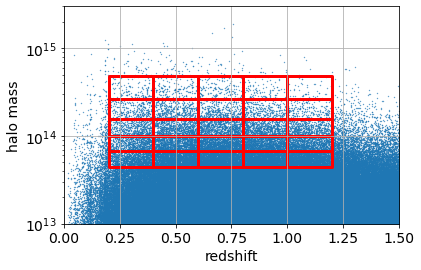

In [16]:
plt.scatter(halo_cat['redshift'], halo_cat['halo_mass'], s=0.1)
plt.yscale('log')


plt.xlabel('redshift')
plt.ylabel('halo mass')

plt.gca().add_collection(pc)
plt.grid()

plt.xlim(0,1.5)
plt.ylim(1e13, 3e15);

## Open source catalog 

In [17]:
path_file = '../'

In [18]:
key = 'LBGp'

gal_cat =  pd.read_hdf(path_file + 'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file + "input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null, gal_dens, zmean = dat[np.where(dat[:,0]==key)][0][1:]
print (alpha_cut)
mag_cut

3.320964657712193


25.495

## Selection of squared region 

In [19]:
#DC2 full

selection_halo = ( halo_cat['ra']>50) & ( halo_cat['ra']<73.1) & ( halo_cat['dec']<-27.) & ( halo_cat['dec']>-45.)
selection_source = ( gal_cat['ra']>50) & ( gal_cat['ra']<73.1) & ( gal_cat['dec']<-27.) & ( gal_cat['dec']>-45.)

area_eq = (73.1 - 50)*(-27 - -45.)

print("selected area =" , area_eq, "deg2")

selected area = 415.7999999999999 deg2


## Creation of source catalogs

In [119]:
Np = 2
selection = selection_source & (gal_cat['mag_i_lsst']<mag_cut) & (gal_cat['redshift']>1.5)

cat = treecorr.Catalog(ra = gal_cat['ra'][selection], dec = gal_cat['dec'][selection], k = gal_cat['magnification'][selection], ra_units='deg', dec_units='deg', npatch=Np)

## Create random source catalog with same area

In [123]:
Ntimes = 100
rand = rand_cat(cat, Nobj = cat.ra.size * Ntimes,  patch_centers=cat_lens[0].patch_centers)#, kde=kde)

## Compute count-count correlation functions on the source catalogs

### bin definiton

In [89]:
bin_dict={'min_sep':0.1, 'max_sep':20, 'sep_units':'arcmin','bin_type':'Log','nbins':10, 'var_method':'shot', 'metric': 'Arc'}

In [90]:
ss = treecorr.NNCorrelation(**bin_dict)
ss.process(cat)

In [91]:
rr = treecorr.NNCorrelation(**bin_dict)
rr.process(rand)

In [92]:
sr = treecorr.NNCorrelation(**bin_dict)
sr.process(cat, rand)

In [30]:
xi, varxi = ss.calculateXi(rr, sr)
r = np.exp(ss.meanlogr)
sig = np.sqrt(varxi)

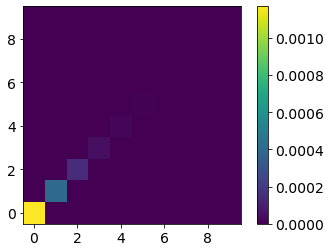

In [31]:
plt.imshow((ss.estimate_cov(bin_dict['var_method'])),origin="lower")
plt.colorbar()

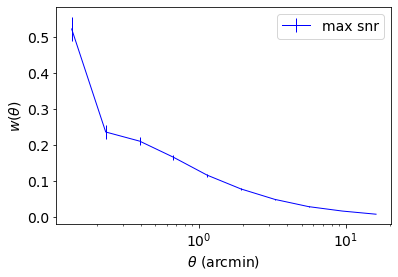

In [32]:
plt.errorbar(r, xi, yerr=sig, color='blue', lw=1, label='max snr')
#plt.errorbar(r_null, xi_null, yerr=sig_null, color='green', lw=1, label='null test')

plt.xscale('log')
#plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$w(\theta)$')

plt.legend()


## Create lens catalogs

In [116]:
bin_dict={'min_sep':0.1, 'max_sep':7,'bin_type':'Log','nbins':10, 'var_method':'shot', 'metric': 'Rlens'}

In [117]:
selection_lens = selection_halo &  wide_selection
redshift_mean, halo_mass_mean = halo_cat['redshift'][selection_lens].mean(), halo_cat['halo_mass'][selection_lens].mean()
print("<z> =", redshift_mean , ", <halo_mass> =", halo_mass_mean/1e14 )

cat_lens = treecorr.Catalog(ra = halo_cat['ra'][selection_halo], dec = halo_cat['dec'][selection_halo], r =  cosmo.angular_diameter_distance(halo_cat['redshift'][selection_halo]).value, ra_units='deg', dec_units='deg', npatch=Np),# patch_centers=cat.patch_centers)

<z> = 0.7332933430025187 , <halo_mass> = 0.8628683058448181


## Compute count-count correlation functions between lens catalog and source catalogs

# $w = \frac{LS - LR - SR +RR}{RR} $ 

 see eq.6 in https://arxiv.org/pdf/1111.3698.pdf

## All halos

In [31]:
r, xi, covxi, r_rand, xi_rand, covxi_rand,  ls, lr, ll = corr_quantities_NN(cat_lens, cat, rand, rr, rd=sr, bin_dict=bin_dict, patch_centers=cat.patch_centers)

sigxi = np.sqrt(np.diag(covxi))
sigxi_rand = np.sqrt(np.diag(covxi_rand))

In [ ]:
r_NK, xi_NK, covxi_NK = corr_quantities_NK(cat_lens, cat, rand, rr, rd=sr, bin_dict=bin_dict, patch_centers=cat.patch_centers)

sigxi_NK = np.sqrt(np.diag(covxi_NK))

In [ ]:
sigxi_NK

In [36]:
def Mpc_to_arcmin(x_Mpc, z=redshift_mean, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z=redshift_mean, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

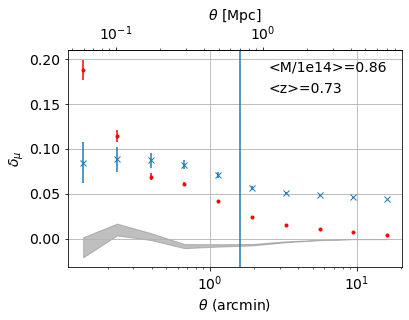

In [38]:
fig, ax =  corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand)

ax.errorbar(r_NK, (xi_NK)**(alpha_cut - 1)-1, yerr= (alpha_cut - 1)*sigxi_NK,fmt='x')

secax = ax.secondary_xaxis('top', functions=( arcmin_to_Mpc, Mpc_to_arcmin))
secax.set_xlabel('$\\theta$ [Mpc]')

r200 = scaled_radius(200, halo_mass_mean, redshift_mean, cosmo)
ax.axvline(Mpc_to_arcmin(r200))

ax.text(0.60, 0.80, "<z>="+str(round(redshift_mean,2)), transform=ax.transAxes)
ax.text(0.60, 0.90, "<M/1e14>="+str(round(halo_mass_mean/1e14,2)), transform=ax.transAxes);

## Halos in bins of mass / redshift

In [85]:
cat_lens_i = np.empty(bin_sel.shape,dtype="object")
quant = np.empty(bin_sel.shape,dtype="object")
quant_NK = np.empty(bin_sel.shape,dtype="object")

In [86]:
bin_dict={'min_sep':0.1, 'max_sep':7,'bin_type':'Log','nbins':10, 'var_method':'shot', 'metric': 'Rlens'}

In [87]:
z_cl = np.zeros((5,5))
mass_cl = np.zeros((5,5))
n_halo = np.zeros((5,5))

for i in np.arange(zbins.shape[0]):
    for j in np.arange(mbins.shape[0]):
        
        selection_lens = selection_halo * bin_sel[i,j]
        z_cl[i,j], mass_cl[i,j] = halo_cat['redshift'][selection_lens].mean(), halo_cat['halo_mass'][selection_lens].mean()
        n_halo[i,j] = halo_cat['redshift'][selection_lens].size
        print("<z> =", z_cl[i,j] , ", <halo_mass> =", mass_cl[i,j]/1e14, "N halo :", n_halo[i,j])

 
        cat_lens_i[i,j] = treecorr.Catalog(ra = halo_cat['ra'][selection_lens], dec = halo_cat['dec'][selection_lens], r = cosmo.angular_diameter_distance(halo_cat['redshift'][selection_lens]).value, ra_units='deg', dec_units='deg', patch_centers=cat.patch_centers)
        print("cat_lens_done")
        
        #quant[i,j] = corr_quantities_NN(cat_lens_i[i,j], cat, rand, bin_dict=bin_dict, patch_centers=cat.patch_centers)[0:6]
        
        print("quant_done")
        quant_NK[i,j] = corr_quantities_NK(cat_lens_i[i,j], cat, bin_dict=bin_dict, patch_centers=cat.patch_centers)

<z> = 0.31607957121219615 , <halo_mass> = 0.5368857375264066 N halo : 1142.0
cat_lens_done
quant_done
         Reshaping from (114200, 1) to (114200,)
3d spherical


/pbs/throng/lsst/users/mricci/desc/my_clean_env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


ValueError: Invalid coords None

TypeError: corr_plot() missing 3 required positional arguments: 'r_rand', 'xi_rand', and 'sigxi_rand'

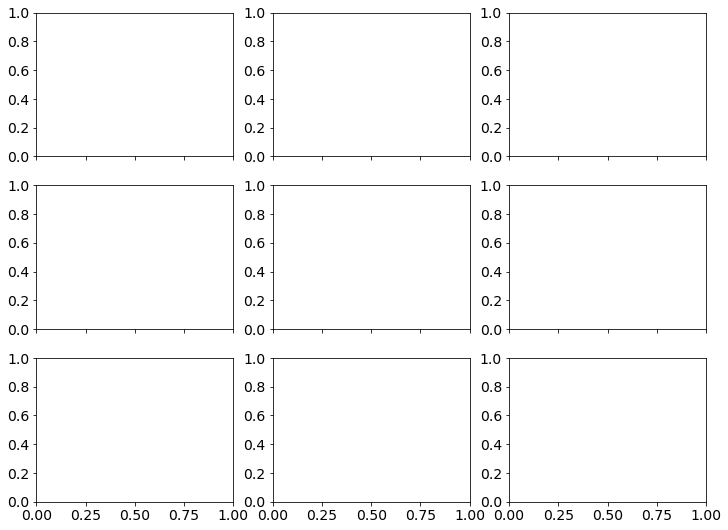

In [53]:

fig, axes = plt.subplots( 3,3, figsize=[12,9], sharex=True)
for i,h in zip([0,2,4],range(3)):
    for j,k in zip([0,2,4],range(3)):
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        f, ax =  corr_plot(*quant[i,j], fig=fig, ax=axes[3-1-k,h], corr=True)

        #ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
        
        ax.set_xlim(0.1,10)
        
        ax2 = ax.twiny()
        ax2.set_xlabel('$\\theta$ [Mpc]')
        ax2.set_xscale('log')
        #ax2.set_xlim(arcmin_to_Mpc(0.1,z=z_cl[i,j], cosmo=cosmo),arcmin_to_Mpc(10.,z=z_cl[i,j], cosmo=cosmo))
        
        #secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        #secax.set_xlabel('$\\theta$ [Mpc]')

        r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        #ax.axvline(Mpc_to_arcmin(r200, z=z_cl[i,j], cosmo=cosmo))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        #ax.axvspan(func_Mpc_to_arcmin(0.2), func_Mpc_to_arcmin(3.5), color='green', alpha=0.1, lw=0)
        
        
plt.tight_layout()

for i in range(axes.shape[0]):
    axes[2,i].set_ylim(-0.5,1)
    axes[1,i].set_ylim(-1,2)
    axes[0,i].set_ylim(-3,6)
    for j in range(axes.shape[1]):
        axes[i,j].set_xlim(0.1,10)

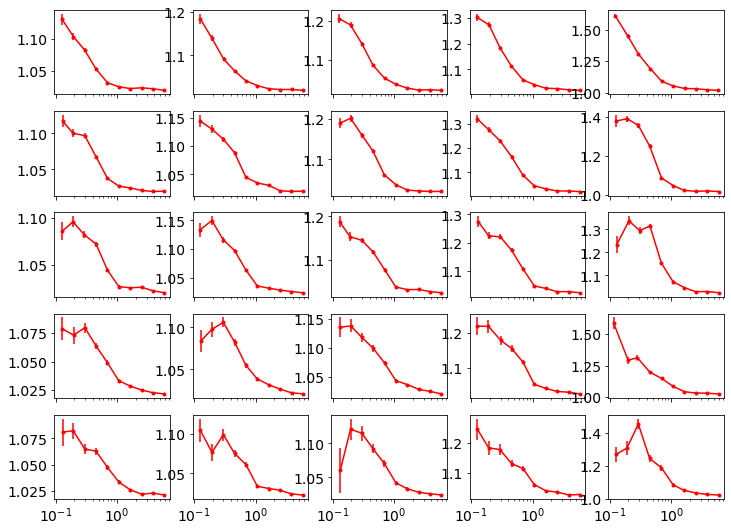

In [45]:
i,j= 1,4

fig, axes = plt.subplots(5,5, figsize=[12,9], sharex=True)


[axes[0,j].errorbar(quant_NK[0,j][0],quant_NK[0,j][1],np.sqrt(np.diag(quant_NK[0,j][2])), color='red', fmt='.-') for j in range(5)]
[axes[1,j].errorbar(quant_NK[1,j][0],quant_NK[1,j][1],np.sqrt(np.diag(quant_NK[1,j][2])), color='red', fmt='.-') for j in range(5)]
[axes[2,j].errorbar(quant_NK[2,j][0],quant_NK[2,j][1],np.sqrt(np.diag(quant_NK[2,j][2])), color='red', fmt='.-') for j in range(5)]
[axes[3,j].errorbar(quant_NK[3,j][0],quant_NK[3,j][1],np.sqrt(np.diag(quant_NK[3,j][2])), color='red', fmt='.-') for j in range(5)]
[axes[4,j].errorbar(quant_NK[1,j][0],quant_NK[4,j][1],np.sqrt(np.diag(quant_NK[4,j][2])), color='red', fmt='.-') for j in range(5)]

#ax.grid()
axes[0,0].set_xscale('log')
#ax.set_xlabel(r'$\theta$ (arcmin)')
#ax.set_ylabel(r'$\delta_{\mu}$')

In [54]:
np.save(path_file + 'output_data/binned_correleation_fct_Mpc_'+key, quant)
np.save(path_file + 'output_data/binned_correleation_fct_NK_Mpc_'+key, quant_NK)

In [111]:
#np.save("halo_bin_properties", [z_cl, mass_cl,n_halo])

# Annexe 

In [73]:
# correlation fct for individual clusters 

xi1 = 0
sigxi1 = 0
xi_rand1 = 0
sigxi_rand1 = 0


for k in range(halo_cat['ra'][selection_halo* bin_sel[0,0]].size):
    cat_lens = treecorr.Catalog(ra = np.reshape(halo_cat['ra'][selection_halo*bin_sel[0,0]].iloc[k], -1), dec = np.reshape(halo_cat['dec'][selection_halo*bin_sel[0,0]].iloc[k],-1), ra_units='deg', dec_units='deg')
    r1, xi01, sigxi01, r_rand1, xi0_rand1, sigxi0_rand1 = corr_quantities(cat_lens, cat, rand, rr, rd=sr, bin_dict=bin_dict);
    xi1 = xi1 + xi01
    varxi1 = sigxi1**2 + sigxi01**2
    xi_rand1 = xi_rand1 + xi0_rand1
    varxi_rand1 = sigxi_rand1**2 + sigxi0_rand1**2

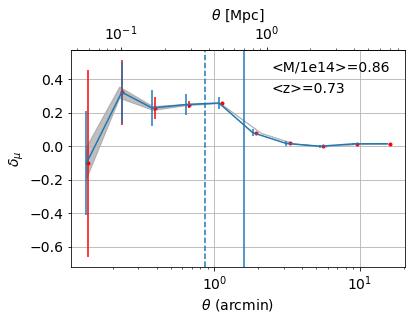

In [83]:
# correlation fct for individual clusters 


N = (halo_cat['ra'][selection_halo*bin_sel[0,0]].size)

yerr=np.sqrt(np.diag(varxi1)/N**(3/2.))
#yerr=np.zeros(10)


fig, ax =  corr_plot(r, xi1/N, yerr, r_rand1, xi_rand1/N, np.sqrt(np.diag(varxi_rand1))/N)

ax.errorbar(quant[0,0][0]*0.95, quant[0,0][1], yerr=np.sqrt(np.diag(quant[0,0][2])), fmt='')

ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")

secax = ax.secondary_xaxis('top', functions=( arcmin_to_Mpc, Mpc_to_arcmin))
secax.set_xlabel('$\\theta$ [Mpc]')

r200 = scaled_radius(200, halo_mass_mean, redshift_mean, cosmo)
ax.axvline(Mpc_to_arcmin(r200))

#ax.errorbar(r_null*1.05, xi_null, yerr= sigxi_null, color='green', fmt='.')

ax.text(0.60, 0.80, "<z>="+str(round(redshift_mean,2)), transform=ax.transAxes)
ax.text(0.60, 0.90, "<M/1e14>="+str(round(halo_mass_mean/1e14,2)), transform=ax.transAxes);


In [40]:
# correlation fct for individual clusters 

xi1 = 0
sigxi1 = 0
xi_rand1 = 0
sigxi_rand1 = 0


for k in range(halo_cat['ra'][selection_halo* wide_selection].size):
    cat_lens = treecorr.Catalog(ra = np.reshape(halo_cat['ra'][selection_halo*wide_selection].iloc[k], -1), dec = np.reshape(halo_cat['dec'][selection_halo*wide_selection].iloc[k],-1), ra_units='deg', dec_units='deg')
    r1, xi01, sigxi01, r_rand1, xi0_rand1, sigxi0_rand1, ls1, lr1, ll1 = corr_quantities(cat_lens, cat, rand, rr, rd=sr, bin_dict=bin_dict);
    xi1 = xi1 + xi01
    varxi1 = sigxi1**2 + sigxi01**2
    xi_rand1 = xi_rand1 + xi0_rand1
    varxi_rand1 = sigxi_rand1**2 + sigxi0_rand1**2

In [75]:
# correlation fct for individual clusters 

xi1 = 0
sigxi1 = 0
xi_rand1 = 0
sigxi_rand1 = 0


for k in range(halo_cat['ra'][selection_halo* wide_selection].size):
    cat_lens = treecorr.Catalog(ra = np.reshape(halo_cat['ra'][selection_halo*wide_selection].iloc[k], -1), dec = np.reshape(halo_cat['dec'][selection_halo*wide_selection].iloc[k],-1), ra_units='deg', dec_units='deg')
    r1, xi1, covxi1, ls1, lrs1, srl1, rlrs1, ll1 = corr_quantities_alt(cat_lens, cat, cat_rand_halo, rand, bin_dict=bin_dict);
    xi1 = xi1 + xi01
    varxi1 = sigxi1**2 + sigxi01**2
    xi_rand1 = xi_rand1 + xi0_rand1
    varxi_rand1 = sigxi_rand1**2 + sigxi0_rand1**2

KeyboardInterrupt: 

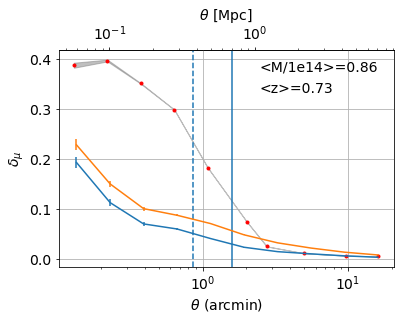

In [54]:
# correlation fct for individual clusters 


N = (halo_cat['ra'][selection_halo*wide_selection].size)

#yerr=np.sqrt(np.diag(varxi1)/N)
yerr=np.zeros(10)


fig, ax =  corr_plot(r1, xi1/N, yerr, r_rand1, xi_rand1/N, np.sqrt(np.diag(varxi_rand1))/N)

ax.errorbar(r, xi, yerr=sigxi, fmt='')

ax.errorbar(r, xi+xi_ll, yerr=sigxi, fmt='')

ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")

secax = ax.secondary_xaxis('top', functions=( arcmin_to_Mpc, Mpc_to_arcmin))
secax.set_xlabel('$\\theta$ [Mpc]')

r200 = scaled_radius(200, halo_mass_mean, redshift_mean, cosmo)
ax.axvline(Mpc_to_arcmin(r200))

#ax.errorbar(r_null*1.05, xi_null, yerr= sigxi_null, color='green', fmt='.')

ax.text(0.60, 0.80, "<z>="+str(round(redshift_mean,2)), transform=ax.transAxes)
ax.text(0.60, 0.90, "<M/1e14>="+str(round(halo_mass_mean/1e14,2)), transform=ax.transAxes);


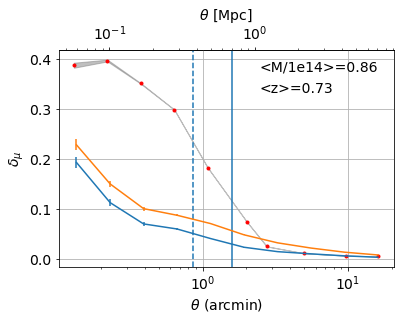

In [54]:
# correlation fct for individual clusters 


N = (halo_cat['ra'][selection_halo*wide_selection].size)

#yerr=np.sqrt(np.diag(varxi1)/N)
yerr=np.zeros(10)


fig, ax =  corr_plot(r1, xi1/N, yerr, r_rand1, xi_rand1/N, np.sqrt(np.diag(varxi_rand1))/N)

ax.errorbar(r, xi, yerr=sigxi, fmt='')

ax.errorbar(r, xi+xi_ll, yerr=sigxi, fmt='')

ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")

secax = ax.secondary_xaxis('top', functions=( arcmin_to_Mpc, Mpc_to_arcmin))
secax.set_xlabel('$\\theta$ [Mpc]')

r200 = scaled_radius(200, halo_mass_mean, redshift_mean, cosmo)
ax.axvline(Mpc_to_arcmin(r200))

#ax.errorbar(r_null*1.05, xi_null, yerr= sigxi_null, color='green', fmt='.')

ax.text(0.60, 0.80, "<z>="+str(round(redshift_mean,2)), transform=ax.transAxes)
ax.text(0.60, 0.90, "<M/1e14>="+str(round(halo_mass_mean/1e14,2)), transform=ax.transAxes);


In [ ]:
def sum_chi2(data, error, model):
    y = (data - model)**2/error**2
    return np.sum(y)

In [ ]:
def c_DuttonMaccio(z, m, h):
    """Concentration from c(M) relation in Dutton & Maccio (2014).
    Parameters
    ----------
    z : float or array_like
        Redshift(s) of halos.
    m : float or array_like
        Mass(es) of halos (m200 definition), in units of solar masses.
    h : float, optional
        Hubble parameter. Default is from Planck13.
    Returns
    ----------
    ndarray
        Concentration values (c200) for halos.
    References
    ----------
    Calculation from Planck-based results of simulations presented in:
    A.A. Dutton & A.V. Maccio, "Cold dark matter haloes in the Planck era:
    evolution of structural parameters for Einasto and NFW profiles,"
    Monthly Notices of the Royal Astronomical Society, Volume 441, Issue 4,
    p.3359-3374, 2014.
    """

    a = 0.52 + 0.385 * np.exp(-0.617 * (z**1.21))  # EQ 10
    b = -0.101 + 0.026 * z                         # EQ 11

    logc200 = a + b * np.log10(m * h / (10.**12))  # EQ 7

    concentration = 10.**logc200

    return concentration

In [ ]:
def conc_child18(z, mass, A=57.6, d=-0.376, m=-0.078):
    """See Table 2 in https://iopscience.iop.org/article/10.3847/1538-4357/aabf95/pdf. Only valid for LCDM cosmology and 0<z<1"""
    c200 = A*(1+z)**d * mass**m
    return c200

In [ ]:
i,j = 0,0
step = 3

chi2_val = np.zeros((z_cl.shape[0], z_cl.shape[1], len(mass_guess)))

for i in range(len(z_cl)):
    for j in range(len(mass)):
        for l in range(len(mass_guess)):
            chi2_val[i,j,l] = chi2(quant[i,j][1][step:], quant[i,j][2][step:], fmodel[i,l](quant[i,j][0][step:]))

In [ ]:
i,j = 0,0
mass_eval = np.zeros((z_cl.shape))
mass_min = np.zeros((z_cl.shape))
mass_max = np.zeros((z_cl.shape))

for i in range(z_cl.shape[0]):
    for j in range(z_cl.shape[1]):
    #eval_mass, eval_mass_min, eval_mass_max 
        mass_eval[i,j], mass_min[i,j], mass_max[i,j] = mass_minimization(chi2_val[i,j,:], mass_guess, s = 1.)
        #print("True mass", mass[i,j]/1e13)
        #print( "evaluated mass =, %1.2e" % results[i,j][0])
        #[print ("sigma =", np.array([1.,2.,3.])[i], ", min mass =", "%1.2e" % eval_mass_min[i], ", max mass =", "%1.2e" % eval_mass_max[i]) for i in range(3)];

In [ ]:
i,j=4,4

plt.plot(mass_guess, chi2_val[i,j,:],'b.-')

plt.xscale('log')
plt.yscale('log')

plt.axvline(mass[i,j], color='red')
plt.axhline(np.min(chi2_val[i,j,:]),  color='black', alpha=1,linestyle="dotted")
plt.axvline(mass_eval[i,j],  color='black', alpha=1,linestyle="dotted")

[plt.axhline(np.min(chi2_val[i,j,:]) + u ) for u in stats.chi2.ppf(stats.chi2.cdf( np.array([1.,2.,3.])**2,1), 1)];

#[plt.axvline(mass_min[i,j][i], alpha=0.5) for i in range(3)];
#[plt.axvline(mass_max[i,j][i], alpha=0.5) for i in range(3)];


plt.ylim(0,100)

In [ ]:
#step = 0
plt.loglog(mass[0,:]*0.90, mass_eval[0,:], "-o", label ="z="+str(round(z_cl[0,0],2)))
plt.loglog(mass[1,:]*0.95, mass_eval[1,:], "-o", label ="z="+str(round(z_cl[1,0],2)))
plt.loglog(mass[2,:]*1.00, mass_eval[2,:], "-o", label ="z="+str(round(z_cl[2,0],2)))
plt.loglog(mass[3,:]*1.05, mass_eval[3,:], "-o", label ="z="+str(round(z_cl[3,0],2)))
plt.loglog(mass[4,:]*1.10, mass_eval[4,:], "-o", label ="z="+str(round(z_cl[4,0],2)))

plt.plot(mass[0,:], mass[0,:], color='black')

plt.legend()

plt.xlabel("mass true")
plt.ylabel("mass eval")

In [ ]:
#step = 1
plt.loglog(mass[0,:]*0.90, mass_eval[0,:], "-o", label ="z="+str(round(z_cl[0,0],2)))
plt.loglog(mass[1,:]*0.95, mass_eval[1,:], "-o", label ="z="+str(round(z_cl[1,0],2)))
plt.loglog(mass[2,:]*1.00, mass_eval[2,:], "-o", label ="z="+str(round(z_cl[2,0],2)))
plt.loglog(mass[3,:]*1.05, mass_eval[3,:], "-o", label ="z="+str(round(z_cl[3,0],2)))
plt.loglog(mass[4,:]*1.10, mass_eval[4,:], "-o", label ="z="+str(round(z_cl[4,0],2)))

plt.plot(mass[0,:], mass[0,:], color='black')

plt.legend()

plt.xlabel("mass true")
plt.ylabel("mass eval")

In [ ]:
#step = 2
plt.loglog(mass[0,:]*0.90, mass_eval[0,:], "-o", label ="z="+str(round(z_cl[0,0],2)))
plt.loglog(mass[1,:]*0.95, mass_eval[1,:], "-o", label ="z="+str(round(z_cl[1,0],2)))
plt.loglog(mass[2,:]*1.00, mass_eval[2,:], "-o", label ="z="+str(round(z_cl[2,0],2)))
plt.loglog(mass[3,:]*1.05, mass_eval[3,:], "-o", label ="z="+str(round(z_cl[3,0],2)))
plt.loglog(mass[4,:]*1.10, mass_eval[4,:], "-o", label ="z="+str(round(z_cl[4,0],2)))

plt.plot(mass[0,:], mass[0,:], color='black', lw=2)

plt.legend()

plt.xlabel("mass true")
plt.ylabel("mass eval")

In [ ]:
#step = 3

plt.errorbar(mass[0,:]*0.90, mass_eval[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),fmt='-o', label ="z="+str(round(z_cl[0,0],2)))

plt.errorbar(mass[1,:]*0.95, mass_eval[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),fmt='-o', label ="z="+str(round(z_cl[1,0],2)))

plt.errorbar(mass[2,:]*1.00, mass_eval[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),fmt='-o', label ="z="+str(round(z_cl[2,0],2)))

plt.errorbar(mass[3,:]*1.05, mass_eval[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),fmt='-o', label ="z="+str(round(z_cl[3,0],2)))

plt.errorbar(mass[4,:]*1.10, mass_eval[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

plt.xscale('log')
plt.yscale('log')

plt.plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)

plt.legend()

plt.xlabel("mass true")
plt.ylabel("mass eval")

plt.grid()

In [ ]:
#step = 3

plt.plot(mass[0,:]*0.90, mass_eval[0,:]/(0.5*(mass_max[0,:] - mass_min[0,:])),'-o', label ="z="+str(round(z_cl[0,0],2)))
plt.plot(mass[1,:]*0.95, mass_eval[1,:]/(0.5*(mass_max[1,:] - mass_min[1,:])),'-o', label ="z="+str(round(z_cl[1,0],2)))
plt.plot(mass[2,:]*1.00, mass_eval[2,:]/(0.5*(mass_max[2,:] - mass_min[2,:])),'-o', label ="z="+str(round(z_cl[2,0],2)))
plt.plot(mass[3,:]*1.05, mass_eval[3,:]/(0.5*(mass_max[3,:] - mass_min[3,:])),'-o', label ="z="+str(round(z_cl[3,0],2)))
plt.plot(mass[4,:]*1.10, mass_eval[4,:]/(0.5*(mass_max[4,:] - mass_min[4,:])),'-o', label ="z="+str(round(z_cl[4,0],2)))

plt.xscale('log')

plt.legend()
0.2 Mpc to 3.5 Mpc
plt.xlabel("mass true")
plt.ylabel("mass eval")

plt.grid()

In [ ]:
#step = 3

plt.errorbar(mass[0,:]*0.90, mass_eval[0,:]/mass[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))

plt.errorbar(mass[1,:]*0.95, mass_eval[1,:]/mass[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))

plt.errorbar(mass[2,:]*1.00, mass_eval[2,:]/mass[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))

plt.errorbar(mass[3,:]*1.05, mass_eval[3,:]/mass[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))

plt.errorbar(mass[4,:]*1.10, mass_eval[4,:]/mass[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

plt.xscale('log')

plt.axhline(1, color='black')

plt.legend()

plt.xlabel("mass true")
plt.ylabel("mass eval/mass true")

In [ ]:
j = 0
for i in range(5):
    print(mass[i,j]/1e14, mass_eval[i,j]/1e14, np.array((mass_eval[i,j] - mass_min[i,j], mass_max[i,j] - mass_eval[i,j]))/1e14)

In [7]:
def ra_dec_z_to_Cartesian(ra, dec, redshift, cosmo, observer=np.array([0, 0, 0]), degrees=True):
    #adapted from https:/nbodykit.readthedocs.io/en/latest/_modules/nbodykit/transform.html#SkyToUnitSphere
    "Return Cartesian coordinates in Mpc"
    x,y,z =  ra_dec_z_to_unitSphere(ra, dec, degrees=degrees, frame='icrs')
    dist = cosmo.comoving_distance(redshift).value
    return (x,y,z) *dist + observer[:,None]

In [8]:
def ra_dec_z_to_unitSphere(ra, dec, degrees=True, frame='icrs'):
    #adapted from https://nbodykit.readthedocs.io/en/latest/_modules/nbodykit/transform.html#SkyToUnitSphere
    if frame == 'icrs':
    # no frame transformation
    # put into radians from degrees
        if degrees:
            ra  = ra*u.deg.to(u.rad)
            dec = dec*u.deg.to(u.rad)

    # cartesian coordinates
    x = np.cos( dec ) * np.cos( ra )
    y = np.cos( dec ) * np.sin( ra )
    z = np.sin( dec )
        
    return x,y,z